## Amazon Alexa Review - Sentiment Analysis

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
import xgboost
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import pickle


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhishekamgain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis

In [4]:
data = pd.read_csv(r"Data/amazon_alexa.tsv", delimiter = "\t", quoting = 3)
data.shape

(3150, 5)

In [6]:
data.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,"""I received the echo as a gift. I needed anoth...",1
6,3,31-Jul-18,Sandstone Fabric,"""Without having a cellphone, I cannot use many...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,"""Love it! I’ve listened to songs I haven’t hea...",1


In [8]:
data.drop(["date"],axis = 1, inplace = True)

In [10]:
data

,rating,variation,verified_reviews,feedback
0,5,Charcoal Fabric,Love my Echo!,1
1,5,Charcoal Fabric,Loved it!,1
2,4,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,Charcoal Fabric,Music,1
...,...,...,...,...
3145,5,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,Black Dot,"""I do love these things, i have them running m...",1
3148,5,White Dot,"""Only complaint I have is that the sound quali...",1


In [12]:
data.isnull().sum()

rating              0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [14]:
data[data["verified_reviews"].isna() == True]

,rating,variation,verified_reviews,feedback
473,2,White,NaN,0


In [16]:
data.dropna(inplace = True)

In [18]:
data["length"] = data["verified_reviews"].apply(len)

In [20]:
data

,rating,variation,verified_reviews,feedback,length
0,5,Charcoal Fabric,Love my Echo!,1,13
1,5,Charcoal Fabric,Loved it!,1,9
2,4,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,Charcoal Fabric,Music,1,5
...,...,...,...,...,...
3145,5,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,52
3146,5,Black Dot,"""Listening to music, searching locations, chec...",1,137
3147,5,Black Dot,"""I do love these things, i have them running m...",1,443
3148,5,White Dot,"""Only complaint I have is that the sound quali...",1,382


In [22]:
data.describe()

,rating,feedback,length
count,3149.000000,3149.000000,3149.000000
mean,4.463957,0.918704,132.714513
std,1.067773,0.273332,182.541531
min,1.000000,0.000000,1.000000
25%,4.000000,1.000000,30.000000
50%,5.000000,1.000000,74.000000
75%,5.000000,1.000000,166.000000
max,5.000000,1.000000,2853.000000


In [24]:
data.columns

Index(['rating', 'variation', 'verified_reviews', 'feedback', 'length'], dtype='object')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3149 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3149 non-null   int64 
 1   variation         3149 non-null   object
 2   verified_reviews  3149 non-null   object
 3   feedback          3149 non-null   int64 
 4   length            3149 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 147.6+ KB


In [28]:
print(data.iloc[10]["verified_reviews"])
print(data.iloc[10]["rating"])
print(data.iloc[10]["variation"])
print(data.iloc[10]["feedback"])
print(data.iloc[10]["length"])


"I sent it to my 85 year old Dad, and he talks to it constantly."
5
Charcoal Fabric 
1
65


In [30]:
data.head(5)

,rating,variation,verified_reviews,feedback,length
0,5,Charcoal Fabric,Love my Echo!,1,13
1,5,Charcoal Fabric,Loved it!,1,9
2,4,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,Charcoal Fabric,Music,1,5


In [32]:
data["rating"].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

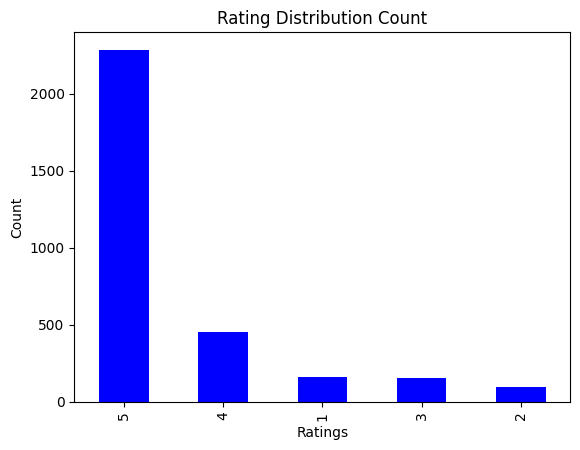

In [34]:
data["rating"].value_counts().plot.bar(color = "blue")
plt.title("Rating Distribution Count")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

print((data["rating"].value_counts()/data.shape[0])*100)

## Analyzing "Feedback" column

In [38]:
data.head(10)["feedback"]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: feedback, dtype: int64

In [40]:
data["feedback"].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

##### Feedback Column describes the type of the feedback. For example: if the feedback is 1 then it means it has the rating of either 5, 4, or 3. Similarly,'if we have feedback of value  0 then it means that the review has rating of either 1 or 2.

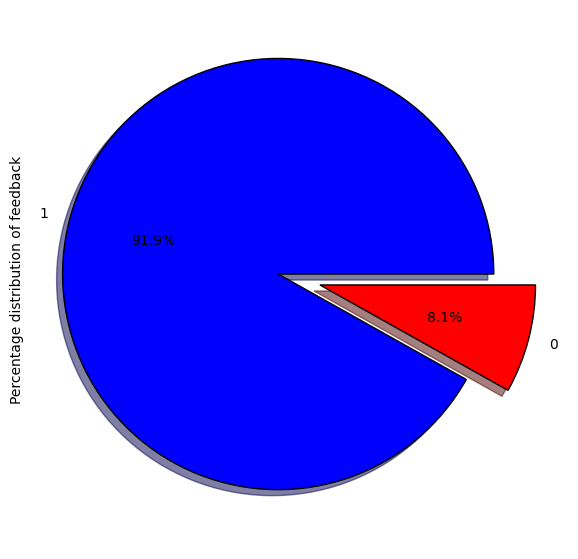

In [43]:
fig = plt.figure(figsize=(7, 7))
colors = ("blue", "red")
wp = {"linewidth": 1, "edgecolor": "black"}
tags = data["feedback"].value_counts() / data.shape[0]
explode = (0.1, 0.1)

# Plot
tags.plot(
    kind="pie",
    wedgeprops=wp,
    autopct="%1.1f%%",
    shadow=True,
    colors=colors,
    explode=explode,
    label="Percentage distribution of feedback"
)

plt.show()


In [44]:
data[data["feedback"] == 1]["rating"].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [47]:
data[data["feedback"] == 0]["rating"].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

## Analyzing Variation Column

In [50]:
print(data["variation"].value_counts())

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


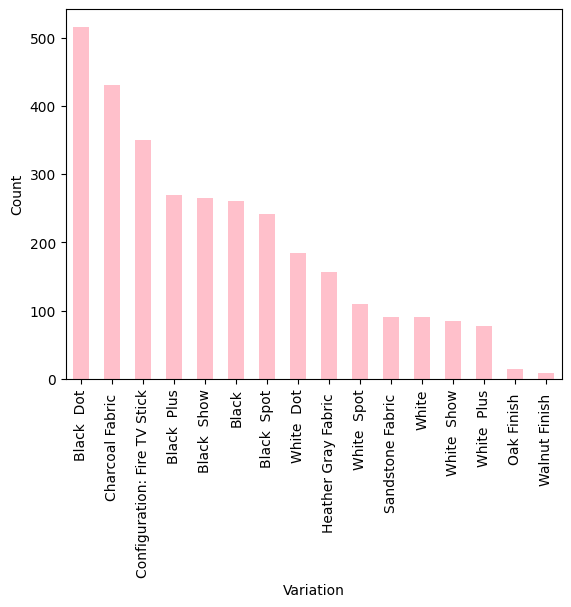

In [52]:
data["variation"].value_counts().plot.bar(color = "pink")
plt.xlabel("Variation")
plt.ylabel("Count")
plt.show()

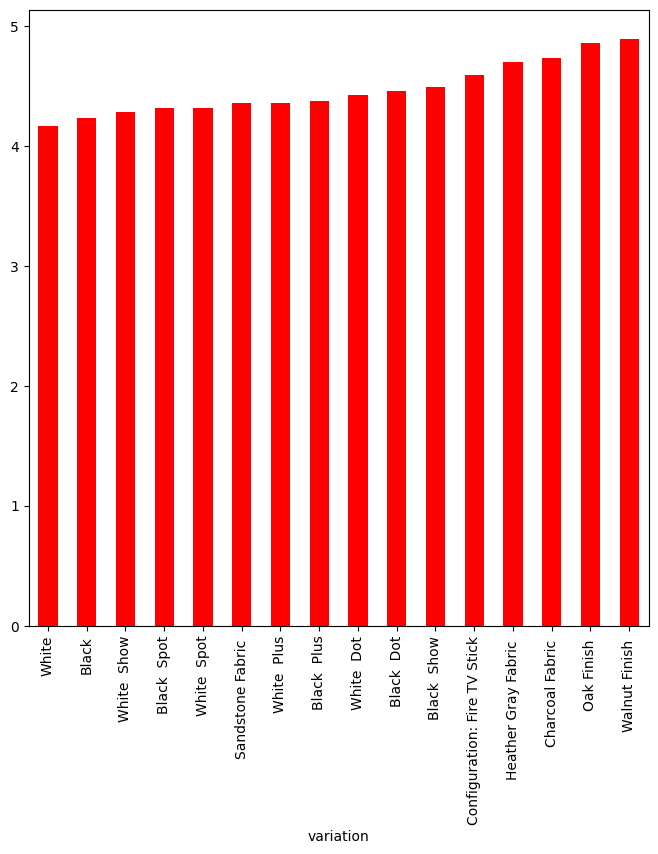

In [54]:
data.groupby("variation")["rating"].mean().sort_values().plot.bar(color = "red", figsize = (8,8))
plt.show()

## Analyzing Verified_Reviews

In [57]:
data.iloc[1]["verified_reviews"]

'Loved it!'

In [59]:
data.iloc[1]["length"]

9

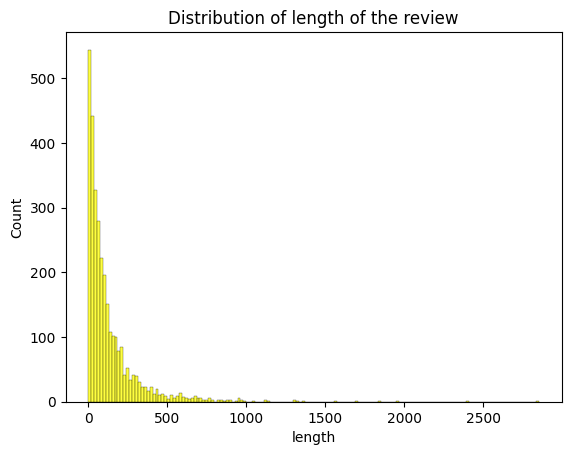

In [61]:
sns.histplot(data["length"], color = "yellow").set(title = "Distribution of length of the review")
plt.show()

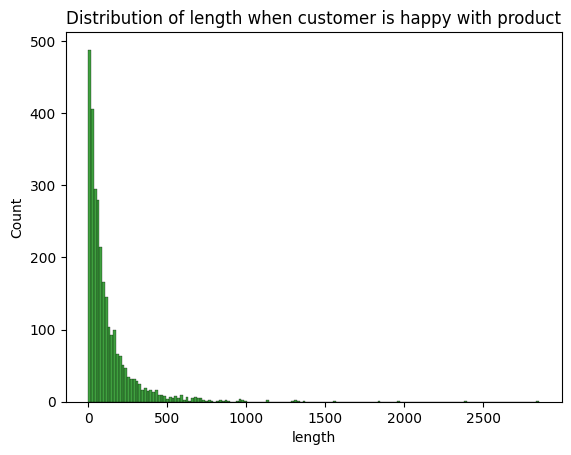

In [63]:
sns.histplot(data[data["feedback"] == 1]["length"], color = "green").set(title = "Distribution of length when customer is happy with product")
plt.show()

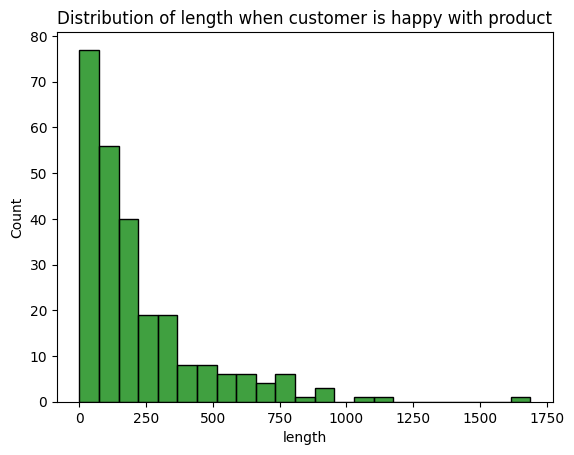

In [65]:
sns.histplot(data[data["feedback"] == 0]["length"], color = "green").set(title = "Distribution of length when customer is happy with product")
plt.show()

##### CountVectorizer is a text preprocessing technique commonly used in natural language processing (NLP) tasks for converting a collection of text documents into a numerical representation. It is part of the scikit-learn library, a popular machine learning library in Python.

In [68]:
cv = CountVectorizer(stop_words = "english")
words = cv.fit_transform(data.verified_reviews)

In [70]:
!pip install WordCloud

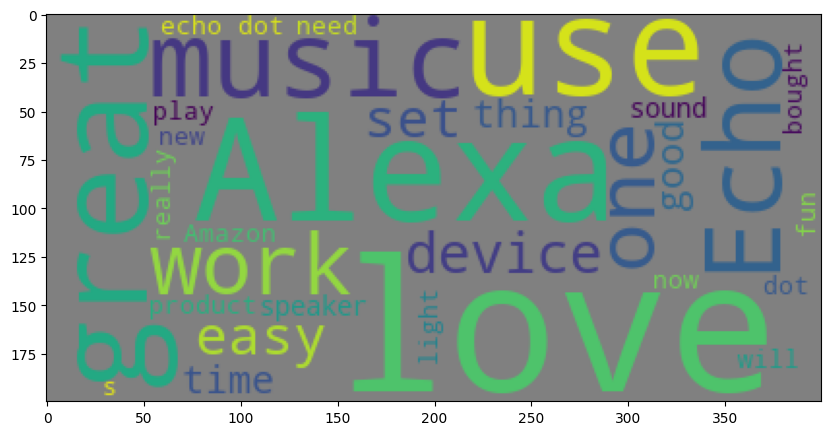

In [72]:
from wordcloud import WordCloud
## Combine all reviews
reviews = " ".join([review for review in data["verified_reviews"]])
wc = WordCloud(background_color = "gray", max_words = 30)
plt.figure(figsize = (10,10))
plt.imshow(wc.generate(reviews))
plt.show()

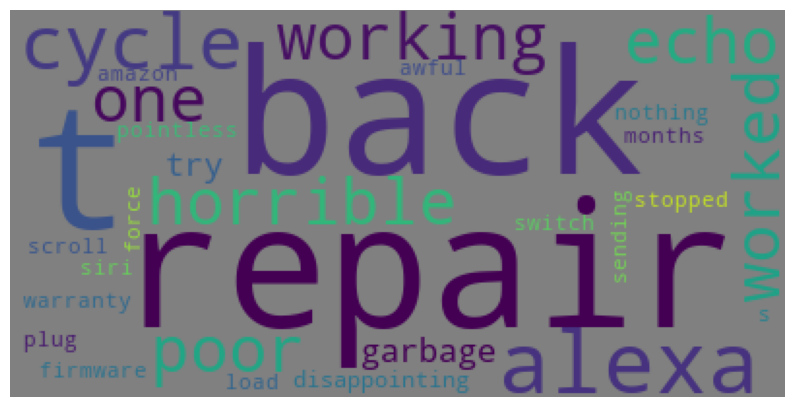

In [74]:
# Lets see the ost common words the people use for the negative feedback
neg_reviews = " ".join([review for review in data[data["feedback"] == 0]["verified_reviews"]])
neg_reviews = neg_reviews.lower().split()
pos_reviews = " ".join([review for review in data[data["feedback"] == 1]["verified_reviews"]])
pos_reviews = pos_reviews.lower().split()
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)
wc = WordCloud(background_color = "gray", max_words = 30)
plt.figure(figsize = (10,10))
plt.imshow(wc.generate(unique_negative))
plt.axis("off")
plt.show()

## Preprocessing and Modelling
##### Lets replace any non-alphabet characters with space. Convert to lower case and split into words. Iterate over the individual words and if it is not a stop word then add the stemmed form of the word to the corpus.

In [77]:
corpus = []
STOPWORD = set(stopwords.words("english"))
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub("[^a-zA-Z]", ' ', data.iloc[i]["verified_reviews"])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORD]
    review = " ".join(review)
    corpus.append(review)
corpus

['love echo',
 'love',
 'sometim play game answer question correctli alexa say got wrong answer like abl turn light away home',
 'lot fun thing yr old learn dinosaur control light play game like categori nice sound play music well',
 'music',
 'receiv echo gift need anoth bluetooth someth play music easili access found smart speaker wait see els',
 'without cellphon cannot use mani featur ipad see use great alarm u r almost deaf hear alarm bedroom live room reason enough keep fun ask random question hear respons seem smartbon polit yet',
 'think th one purchas work get one everi room hous realli like featur offer specifili play music echo control light throughout hous',
 'look great',
 'love listen song heard sinc childhood get news weather inform great',
 'sent year old dad talk constantli',
 'love learn knew thing eveyday still figur everyth work far easi use understand make laugh time',
 'purchas mother knee problem give someth tri come get around fast like enjoy littl big thing ale

## Using CountVectorizer to create bag of words

In [80]:
cv = CountVectorizer(max_features = 2500)

X = cv.fit_transform(corpus).toarray()
Y = data["feedback"].values

In [82]:
pickle.dump(cv, open("Models/countVectorizer.pkl","wb"))

In [84]:
Y.shape

(3149,)

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 13)


In [88]:
X_train.max()

12

### Lets Scale X_Train and X_Test so that all values are between 0 and 1

In [91]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.fit_transform(X_test)

In [93]:
## Saving the scaler mode
pickle.dump(scaler, open("Models/scaler.pkl","wb"))

## Use XgBoost Classifier

In [96]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [98]:
print(model_xgb.score(X_train_scl, Y_train))
print(model_xgb.score(X_test_scl, Y_test))


0.9670504168320763
0.9492063492063492


In [100]:
y_preds = model_xgb.predict(X_test)

In [102]:
cm = confusion_matrix(Y_test, y_preds)
print(cm)

[[ 21  22]
 [  8 579]]


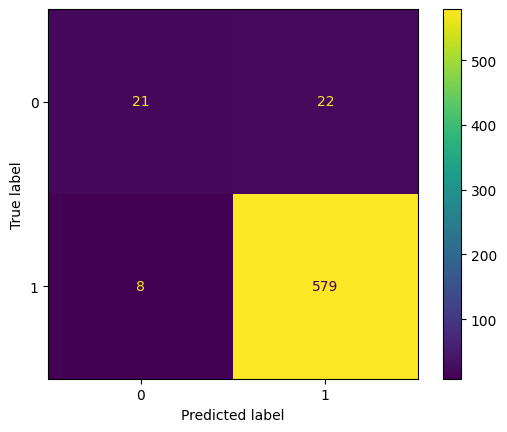

In [104]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_xgb.classes_)
cm_display.plot()
plt.show()

In [ ]:
text = "The product was very bad."


In [106]:
## Save the XGBoost Classifier
pickle.dump(model_xgb, open("Models/model_xgb.pkl", "wb"))